In [138]:
import sys
sys.path.append('..')
import sklearn
from tsai.basics import *
from swdf.utils import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from itertools import chain


os              : Linux-6.8.0-35-generic-x86_64-with-glibc2.31
python          : 3.9.17
tsai            : 0.3.10
fastai          : 2.7.14
fastcore        : 1.5.29
sklearn         : 1.4.1.post1
torch           : 2.2.2+cu121
device          : cpu
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [139]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_solfsmy = config_solfsmy.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_solfsmy})
# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()
config

```json
{ 'add_time_channels': False,
  'arch': { 'decomposition': True,
            'individual': True,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data_columns_fcst': ['F10', 'S10', 'M10', 'Y10'],
  'data_path': '../data/SOLFSMY.TXT',
  'data_url': 'https://sol.spacenvironment.net/jb2008/indices/SOLFSMY.TXT',
  'horizon': 6,
  'init_weights': False,
  'lookback': 36,
  'lr_max': None,
  'n_epoch': 5,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [140]:
data_columns = ['F10', 'S10', 'M10', 'Y10']

df = load_object("preprocessed_data/dataframes/solfsmy.pkl")
df.head(10)

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00
5,1997,6,2450455.0,73.099998,76.500000,77.699997,78.900002,71.599998,73.199997,66.300003,69.300003,1B11,1,B,1,1,1997-01-06 12:00:00
6,1997,7,2450456.0,73.300003,76.099998,77.900002,78.800003,70.099998,73.099998,67.500000,69.000000,1B11,1,B,1,1,1997-01-07 12:00:00
7,1997,8,2450457.0,73.800003,75.800003,78.699997,78.699997,74.000000,73.000000,67.900002,68.800003,1B11,1,B,1,1,1997-01-08 12:00:00
8,1997,9,2450458.0,73.699997,75.599998,79.900002,78.699997,74.699997,72.900002,66.900002,68.599998,1B11,1,B,1,1,1997-01-09 12:00:00
9,1997,10,2450459.0,75.400002,75.400002,80.300003,78.699997,76.300003,72.800003,70.500000,68.300003,1B11,1,B,1,1,1997-01-10 12:00:00


In [141]:
df_time = df.copy()
df_time.set_index('Date', inplace=True)
weekly_groups = list(df_time.resample('7D').indices.values())

In [142]:
# Lists to hold the intervals for each set
training_intervals = []
training_combinations = []
testing_intervals = []
testing_combinations = []
validation_intervals = []
validation_combinations = []

# Iterate over the groups in chunks of 10 weeks
for i in range(0, len(list(weekly_groups)), 10):
    chunk = list(weekly_groups)[i:i+10]
   
    # Extract intervals for training, testing, and validation
    if len(chunk) >= 6:
        training_combinations += list(np.arange(i, i+6))
        training_intervals.append((chunk[:6]))
    if len(chunk) >= 8:
        testing_combinations += list(np.arange(i+6, i+8))
        testing_intervals.append(chunk[6:8])
    if len(chunk) >= 10:
        validation_combinations += list(np.arange(i+8, i+10))
        validation_intervals.append(chunk[8:10])

validation_intervals.__delitem__(-1) # To avoid unhomegeneous arrays
validation_intervals.__delitem__(-1)

([8,
  9,
  18,
  19,
  28,
  29,
  38,
  39,
  48,
  49,
  58,
  59,
  68,
  69,
  78,
  79,
  88,
  89,
  98,
  99,
  108,
  109,
  118,
  119,
  128,
  129,
  138,
  139,
  148,
  149,
  158,
  159,
  168,
  169,
  178,
  179,
  188,
  189,
  198,
  199,
  208,
  209,
  218,
  219,
  228,
  229,
  238,
  239,
  248,
  249,
  258,
  259,
  268,
  269,
  278,
  279,
  288,
  289,
  298,
  299,
  308,
  309,
  318,
  319,
  328,
  329,
  338,
  339,
  348,
  349,
  358,
  359,
  368,
  369,
  378,
  379,
  388,
  389,
  398,
  399,
  408,
  409,
  418,
  419,
  428,
  429,
  438,
  439,
  448,
  449,
  458,
  459,
  468,
  469,
  478,
  479,
  488,
  489,
  498,
  499,
  508,
  509,
  518,
  519,
  528,
  529,
  538,
  539,
  548,
  549,
  558,
  559,
  568,
  569,
  578,
  579,
  588,
  589,
  598,
  599,
  608,
  609,
  618,
  619,
  628,
  629,
  638,
  639,
  648,
  649,
  658,
  659,
  668,
  669,
  678,
  679,
  688,
  689,
  698,
  699,
  708,
  709,
  718,
  719,
  728,
  729,


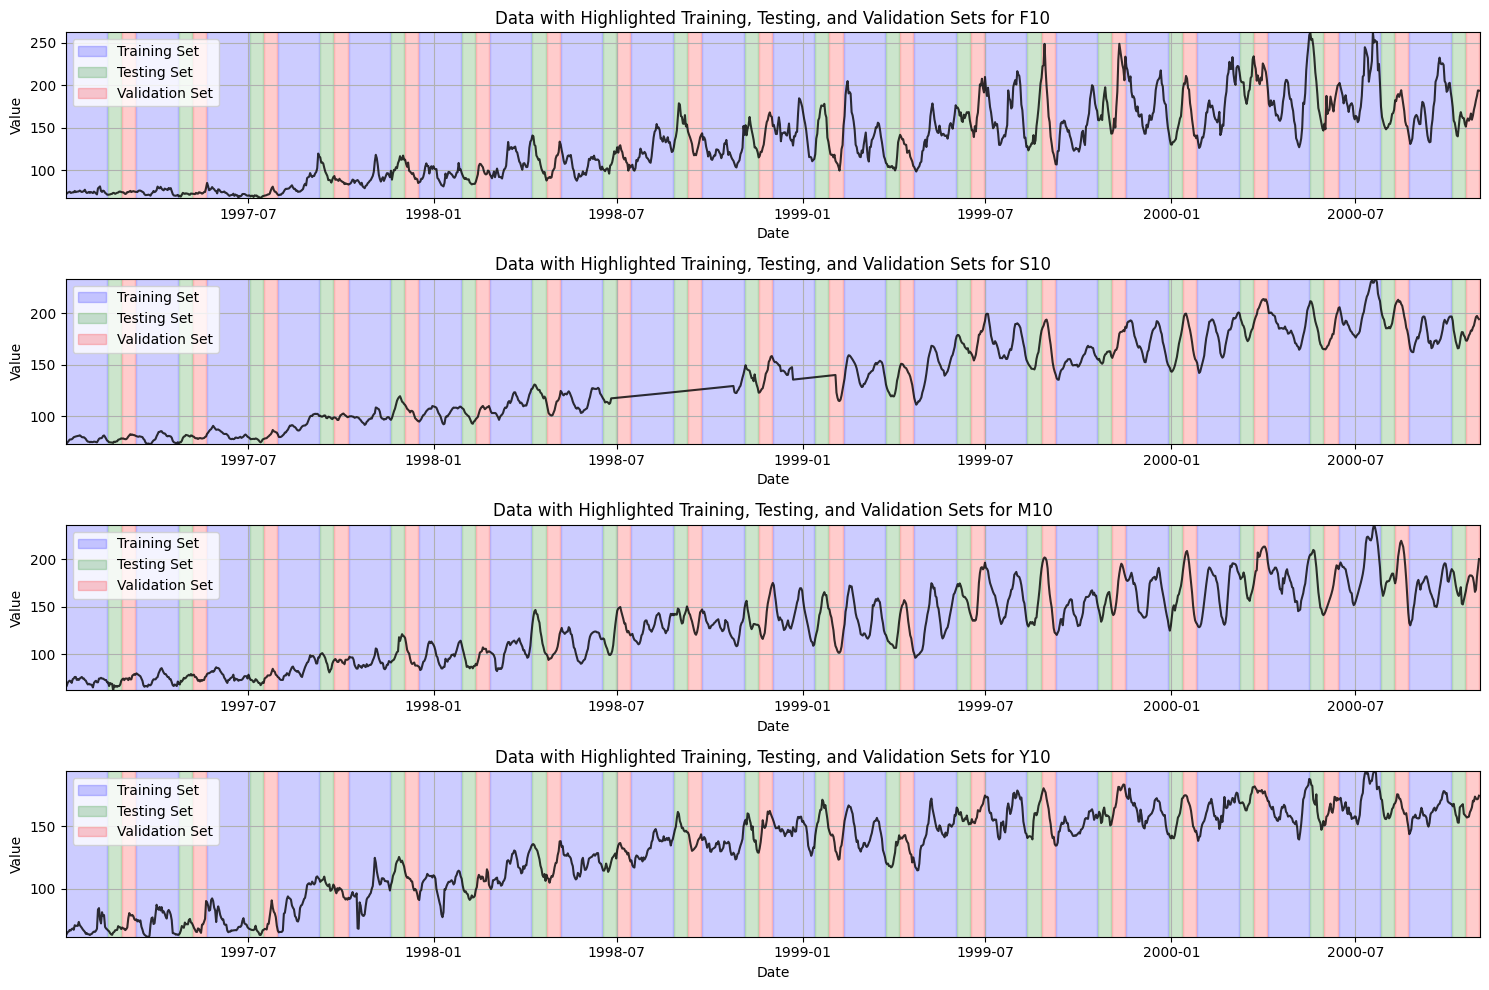

In [143]:
# Assuming df is your DataFrame and training_intervals, testing_intervals, validation_intervals are your interval lists
columns = ['F10', 'S10', 'M10', 'Y10']
full_intervals = 20

# Function to plot shaded intervals
def plot_intervals(ax, intervals, color, label, column):
    for interval in intervals:
        interval = chain.from_iterable(interval)
        ax.fill_between(df.Date.loc[interval], df[column].min(), df[column].max(), color=color, alpha=0.2, label=label)
        label = None  # Avoid duplicate labels in legend

# Create a figure and subplots
fig, axs = plt.subplots(len(columns), 1, figsize=(15, 10))

# Ensure axs is always a list for consistency
if len(columns) == 1:
    axs = [axs]

for ax, column in zip(axs, columns):
    # Plotting each set with a different color
    plot_intervals(ax, training_intervals[:full_intervals], 'blue', 'Training Set', column)
    plot_intervals(ax, testing_intervals[:full_intervals], 'green', 'Testing Set', column)
    plot_intervals(ax, validation_intervals[:full_intervals], 'red', 'Validation Set', column)

    # Define the plot period for each column
    plot_period = df.Date < df.Date.min() + pd.Timedelta(weeks=full_intervals*10)
    ax.plot(df[plot_period]['Date'], df[plot_period][column], alpha=0.8, color='black')

    # Enhancing the plot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_title(f'Data with Highlighted Training, Testing, and Validation Sets for {column}')
    ax.set_xlim((df.Date.min(), df.Date.min() + pd.Timedelta(weeks=full_intervals*10)))
    ax.set_ylim((df[plot_period][column].min(), df[plot_period][column].max()))
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

In [144]:
import more_itertools as mit

def sliding_window_generator(df, split_start, comb=None, segments=None):
    consecutive_elements, X, y = None, None, None

    if comb is not None:
        consecutive_elements = [list(group) for group in mit.consecutive_groups(comb)]

        df_to_window = []
        for elements in consecutive_elements:
            best_comb_idxs = [segments[i] for i in elements]
            df_to_window.append(df.iloc[chain.from_iterable(best_comb_idxs)])
    else:
        df_to_window = [df]
    
    X_window, y_window = None, None 
    for df_window in df_to_window:    
        X_window, y_window = SlidingWindow(
            window_len=9,
            horizon=3, 
            stride=1, 
            get_x=data_columns, 
            get_y=data_columns
        )(df_window)
        
        X = np.concatenate([X, X_window]) if X is not None else X_window
        y = np.concatenate([y, y_window]) if y is not None else y_window
    
    
    splits = L(list(np.arange(split_start, len(X)+split_start)))
    return X, y, splits


X_val, y_val, split_val = sliding_window_generator(df, 0, comb=validation_combinations, segments=weekly_groups)
X_train, y_train, split_train = sliding_window_generator(df, split_val[-1]+1, comb=training_combinations, segments=weekly_groups)
X_test, y_test, split_test = sliding_window_generator(df, split_train[-1]+1, comb=testing_combinations, segments=weekly_groups) 

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)
splits, X.shape, y.shape

(((#4216) [408,409,410,411,412,413,414,415,416,417...],
  (#408) [0,1,2,3,4,5,6,7,8,9...],
  (#408) [4624,4625,4626,4627,4628,4629,4630,4631,4632,4633...]),
 (5032, 4, 9),
 (5032, 4, 3))

In [145]:
thresholds = yaml2dict("distributions/thresholds.yaml")
thresholds

```json
{ 'F10': [(0, 75), (76, 150), (151, 190), (191, inf)],
  'M10': [(0, 72), (73, 144), (145, 167), (168, inf)],
  'S10': [(0, 65), (66, 150), (151, 215), (216, inf)],
  'Y10': [(0, 81), (82, 148), (149, 165), (166, inf)]}
```

In [146]:
preproc_pipe = load_object("tmp/pipes/preproc_pipe.pkl")
exp_pipe = load_object("tmp/pipes/exp_pipe.pkl")

ranges = load_object("tmp/loss_param/ranges.pkl")

historical_dist =  np.array(list(get_F10_historical_distribution(thresholds).values()))

weights = 1.0 - historical_dist
solact_distribution = weights * (1.0 / sum(weights))

solact_levels = None

epoch,train_loss,valid_loss,loss_low,loss_moderate,loss_elevated,loss_high,time
0,26.400801,16.291498,0.736581,9.334394,3.100908,3.119617,00:02
1,20.813931,29.029305,0.975477,17.260759,4.762389,6.030677,00:02
2,17.557100,21.490847,0.802119,11.728141,4.086774,4.873810,00:02
3,16.120644,17.781599,0.777335,9.218472,3.532809,4.252984,00:02
4,15.019649,11.025804,0.636580,5.848680,2.262022,2.278522,00:02


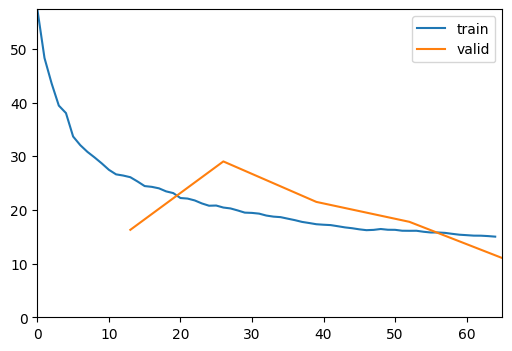

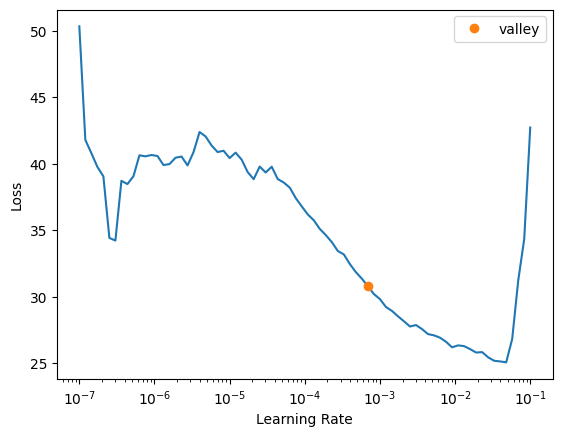

In [147]:
from swdf.losses import wMSELoss, LossMetrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = wMSELoss(ranges, solact_distribution, solact_levels).to(device)
metrics = LossMetrics(loss).metrics()

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max

learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)


In [151]:
# Save everything
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.save_all(path='tmp', verbose=True) 


Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth', 'dls_4.pth', 'dls_5.pth', 'dls_6.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'
